In [49]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import kagglehub
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
import seaborn as sns







In [50]:
# Load the Breast Cancer Wisconsin Dataset from Kaggle

path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2


In [51]:
# Read the dataset
path = "/root/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2/data.csv"

data = pd.read_csv(path, encoding='latin-1', sep=',')

# Data Preprocessing
# Drop irrelevant columns ('id' and 'Unnamed: 32')

data.drop(labels = ['id','Unnamed: 32'],axis = 1,inplace = True)

# Encode the target column 'diagnosis' into numerical values (1 for Malignant, 0 for Benign)



label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])
print(data.head())

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

In [52]:
# displaying highly correlated features 
corr_matrix = data.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

highcorrfeatures = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"{highcorrfeatures}")

['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [53]:
# Remove highly correlated features to avoid multicollinearity
data.columns = data.columns.str.strip()
data.drop(labels = ['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst'
], axis = 1, inplace = True)

# Normalize the dataset using MinMaxScaler


scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=['float64']).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
print(data.head())







   diagnosis  radius_mean  texture_mean  smoothness_mean  compactness_mean  \
0          1     0.521037      0.022658         0.593753          0.792037   
1          1     0.643144      0.272574         0.289880          0.181768   
2          1     0.601496      0.390260         0.514309          0.431017   
3          1     0.210090      0.360839         0.811321          0.811361   
4          1     0.629893      0.156578         0.430351          0.347893   

   concavity_mean  symmetry_mean  fractal_dimension_mean  radius_se  \
0        0.703140       0.686364                0.605518   0.356147   
1        0.203608       0.379798                0.141323   0.156437   
2        0.462512       0.509596                0.211247   0.229622   
3        0.565604       0.776263                1.000000   0.139091   
4        0.463918       0.378283                0.186816   0.233822   

   texture_se  ...  compactness_se  concavity_se  concave points_se  \
0    0.120469  ...        0.35139

In [54]:
# Split the dataset into training, validation, and test sets
X = data.drop('diagnosis', axis=1)
#y will be the target
y = data['diagnosis']
#split the data to 60% training and 40% remaining
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)
# remaining data to 20% cross-validation and 20% testing
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)



In [55]:
#hyperparameter ranges
kerneltypes = ['linear', 'poly', 'rbf']
Cvalues = [0.001, 0.01, 0.1, 1, 10, 100,1000]
gammavalues = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
degreevalues = [1, 2, 3, 4, 5, 6]
results = []

#  loop through all hyperparameters
for kernel in kerneltypes:
    for C in Cvalues:

        degree_range = degreevalues if kernel == 'poly' else [None]

        for degree in degree_range:
            for gamma in gammavalues:
                if kernel == 'poly':
                    model = SVC(kernel=kernel, C=C, degree=degree, gamma=gamma)
                else:
                    model = SVC(kernel=kernel, C=C, gamma=gamma)

                model.fit(X_train, y_train)

                y_val_pred = model.predict(X_val)
                validation_accuracy = accuracy_score(y_val, y_val_pred)

                results.append({
                    'kernel': kernel,
                    'C': C,
                    'degree': degree,
                    'gamma': gamma,
                    'cv_accuracy': validation_accuracy,

                })


In [56]:
#displaying top 3 cross validation results
top_results_cv = results_df.sort_values(by='cv_accuracy', ascending=False).head(3)
print("Top 3 Cross-Validation Results:")
print(top_results_cv)

Top 3 Cross-Validation Results:
    kernel       C  degree  gamma  cv_accuracy
303   poly  1000.0     1.0   0.01     0.991228
186   poly     1.0     2.0   1.00     0.991228
180   poly     1.0     1.0  10.00     0.991228



The top three results show that the polynomial kernel performs best. The first model with C equal to 1000, degree of 1, and gamma of 0.01 achieves the highest cross-validation accuracy of 0.991228. This model will be used for final testing accuracy because of its strong performance and good balance of complexity.


In [57]:

best_kernel = top_results_cv.iloc[0]['kernel']
best_C = top_results_cv.iloc[0]['C']
best_degree = top_results_cv.iloc[0]['degree'] if best_kernel == 'poly' else None
best_gamma = top_results_cv.iloc[0]['gamma']


best_model = SVC(kernel=best_kernel, C=best_C, degree=int(best_degree) if best_kernel == 'poly' else None, gamma=best_gamma)

best_model.fit(X_train, y_train)


y_test_pred = best_model.predict(X_test)


test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Final Test Accuracy: {test_accuracy}")


Final Test Accuracy: 0.9736842105263158


The final test accuracy of 0.9737 shows that the model does a great job on new, unseen data. Since it had a high cross-validation accuracy of 0.9912, the slight drop in test accuracy is expected and still solid. This means the chosen hyperparameters are working well, balancing fitting the data without overfitting, and the model is reliable for making predictions.








In [58]:
svm_model = SVC(kernel='poly', C=1000, degree=1, gamma=0.01)

svm_model.fit(X_train, y_train)

from sklearn.inspection import permutation_importance

result = permutation_importance(svm_model, X_train, y_train, n_repeats=10, random_state=42)
feature_importance = result.importances_mean

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                    Feature  Importance
4            concavity_mean    0.083871
0               radius_mean    0.057185
18           symmetry_worst    0.044575
17          concavity_worst    0.035484
1              texture_mean    0.029326
7                 radius_se    0.022581
6    fractal_dimension_mean    0.012317
15         smoothness_worst    0.012023
12        concave points_se    0.009091
14     fractal_dimension_se    0.000587
16        compactness_worst    0.000000
19  fractal_dimension_worst    0.000000
11             concavity_se   -0.000293
8                texture_se   -0.000293
10           compactness_se   -0.000880
9             smoothness_se   -0.001760
3          compactness_mean   -0.002639
2           smoothness_mean   -0.002639
13              symmetry_se   -0.003812
5             symmetry_mean   -0.004399


The feature importance results show that "concavity_mean" and "radius_mean" are the most influential features, with the highest importance scores. In contrast, features like "fractal_dimension_mean" and "smoothness_mean" contribute very little to the model. The negative importance for "symmetry_mean" suggests a small inverse relationship with the target, but its effect is minimal.

In [59]:
# set the training size that ranges from 90% to 10%
training_sizes = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

accuracies = []

# start training the model for each size
for size in training_sizes:
    # i split the training data for the current training size
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)

    svm_model = SVC(kernel='linear', C=100.0, gamma=1)
    svm_model.fit(X_train_subset, y_train_subset)

    #  predicted the test set using the trained model
    y_test_pred = svm_model.predict(X_test)

    # calculate and store the accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(test_accuracy)

#  print the results for each training size
for size, accuracy in zip(training_sizes, accuracies):
    print(f"Training Size: {size * 100:.0f}%, Test Accuracy: {accuracy:.4f}")


Training Size: 90%, Test Accuracy: 0.9825
Training Size: 80%, Test Accuracy: 0.9737
Training Size: 70%, Test Accuracy: 0.9649
Training Size: 60%, Test Accuracy: 0.9561
Training Size: 50%, Test Accuracy: 0.9561
Training Size: 40%, Test Accuracy: 0.9649
Training Size: 30%, Test Accuracy: 0.9561
Training Size: 20%, Test Accuracy: 0.9474
Training Size: 10%, Test Accuracy: 0.9211



As the training size decreases, the test accuracy shows a general decline. Initially, with 90% of the data used for training, the model achieves a test accuracy of 98.25%. As the training size reduces, the performance decreases, stabilizing around 95.61% when the training size is 60% or lower. The smallest training size of 10% results in the lowest test accuracy of 92.11%. This suggests that larger training sets lead to better model performance, but the accuracy stabilizes beyond a certain point as the model has enough data for training.

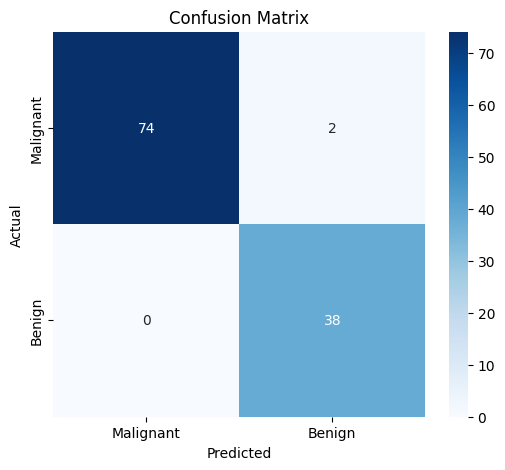

Confusion Matrix:
[[74  2]
 [ 0 38]]
Sensitivity (True Positive Rate): 0.9737
Specificity (True Negative Rate): 1.0000
Accuracy: 0.9825


In [60]:
svm_model = SVC(kernel='linear', C=100.0, gamma=1)
svm_model.fit(X_train, y_train)

y_test_pred_svm = svm_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)

TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[1, 0]
FN = cm[0, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")


The model performs excellently, with a sensitivity of 97.37%, meaning it correctly identifies most malignant cases. It has perfect specificity (100%), indicating no false positives for benign cases. With an overall accuracy of 98.25%, the model reliably distinguishes between malignant and benign tumors, making it highly effective for breast cancer detection.

PART 2 Multinomial Naive Bayes model


In [61]:
# Reading and cleaning the dataset:
path = "/root/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2/data.csv"
data = pd.read_csv(path, encoding='latin-1', sep=',')
data.drop(labels = ['id','Unnamed: 32'],axis = 1,inplace = True)
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])
print(data.head())

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

In [62]:
corr_matrix = data.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

highcorrfeatures = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"{highcorrfeatures}")

['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [63]:
data.columns = data.columns.str.strip()
data.drop(labels = ['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst'
], axis = 1, inplace = True)

scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=['float64']).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
print(data.head())


   diagnosis  radius_mean  texture_mean  smoothness_mean  compactness_mean  \
0          1     0.521037      0.022658         0.593753          0.792037   
1          1     0.643144      0.272574         0.289880          0.181768   
2          1     0.601496      0.390260         0.514309          0.431017   
3          1     0.210090      0.360839         0.811321          0.811361   
4          1     0.629893      0.156578         0.430351          0.347893   

   concavity_mean  symmetry_mean  fractal_dimension_mean  radius_se  \
0        0.703140       0.686364                0.605518   0.356147   
1        0.203608       0.379798                0.141323   0.156437   
2        0.462512       0.509596                0.211247   0.229622   
3        0.565604       0.776263                1.000000   0.139091   
4        0.463918       0.378283                0.186816   0.233822   

   texture_se  ...  compactness_se  concavity_se  concave points_se  \
0    0.120469  ...        0.35139

In [64]:
X1 = data.drop('diagnosis', axis=1)
y1 = data['diagnosis']
X_train1, X_remaining1, y_train1, y_remaining1 = train_test_split(X1, y1, test_size=0.4, random_state=42)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_remaining1, y_remaining1, test_size=0.5, random_state=42)



In [65]:
# Looping over alpha and fit_prior values
alpha_values = [0.1, 0.5, 1.0, 2.0]
fit_prior_values = [True, False]
cv_results = []

for alpha in alpha_values:
    for fit_prior in fit_prior_values:
        nb_model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)

        # getting Cross-validation on training set
        cv_scores = cross_val_score(nb_model, X_train1, y_train1, cv=5, scoring='accuracy')

        #get mean
        mean_cv_score = np.mean(cv_scores)

        # Fiting the model on the training data
        nb_model.fit(X_train1, y_train1)





        cv_results.append({
            'alpha': alpha,
            'fit_prior': fit_prior,
            'cv_mean_accuracy': mean_cv_score,


        })

In [66]:
sorted_cv_results = sorted(cv_results, key=lambda x: x['cv_mean_accuracy'], reverse=True)

# Geting the best two results
top_results = sorted_cv_results[:2]
for result in top_results:
    print(f"Best Alpha: {result['alpha']}, Fit Prior: {result['fit_prior']}, "
          f"Cross-Validation accuracy: {result['cv_mean_accuracy']:.4f},  ")

Best Alpha: 2.0, Fit Prior: False, Cross-Validation accuracy: 0.8682,  
Best Alpha: 0.5, Fit Prior: False, Cross-Validation accuracy: 0.8653,  


The best two configurations (Alpha 2.0 and 0.5) show nearly identical performance, with cross-validation accuracies of 0.8682 and 0.8653 This suggests that small changes in Alpha have minimal impact on the model's performance. Either choice could be effective for the model.

In [67]:
best_alpha = 2.0
best_fit_prior = False

best_nb_model = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)

best_nb_model.fit(X_train1, y_train1)

y_val_pred1 = best_nb_model.predict(X_val1)

y_test_pred1 = best_nb_model.predict(X_test1)
test_accuracy = np.mean(y_test_pred1 == y_test1)


print(f"Test Accuracy: {test_accuracy:.4f}")



Test Accuracy: 0.8246


The test accuracy of 0.8246 means the model correctly predicted 82.5% of the test cases.

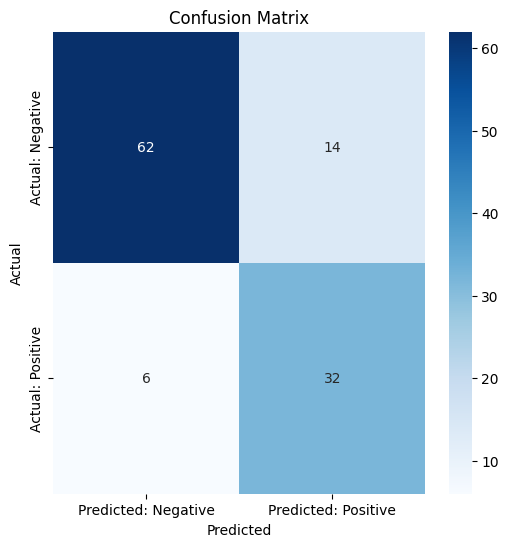

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_alpha = 2.0
best_fit_prior = False

best_nb_model = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
best_nb_model.fit(X_train1, y_train1)

y_test_pred1 = best_nb_model.predict(X_test1)

cm = confusion_matrix(y_test, y_test_pred1)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: Negative', 'Predicted: Positive'], yticklabels=['Actual: Negative', 'Actual: Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix indicates that the model performs reasonably well. It correctly identifies 62 true negatives and 32 true positives. However, there are some misclassifications, with 14 false positives and 6 false negatives. These errors suggest that the model is slightly more prone to over-predicting positives, as evidenced by the higher number of false positives compared to false negatives. Nonetheless, the overall performance is decent, but reducing these misclassifications could improve the model's accuracy and reliability.

# **part3**
**Compare SVM vs NB performance metrics**


**1.SVM Model**   

*  Test Accuracy: 0.9737
*   Confusion Matrix: High true positive and true negative rates, with very few misclassifications.

The SVM model shows strong performance with a test accuracy of 97.37%. The confusion matrix indicates that the model correctly classifies most cases, with minimal misclassifications. This high accuracy means that the model reliably distinguishes between malignant and benign cases, and its strong sensitivity suggests that only a small number of false negatives are present.




**2.  Naive Bayes Model**


*   Test Accuracy: 0.8246
*   Confusion Matrix: 62 true negatives, 32 true positives, 14 false positives, 6 false negatives.

The Naive Bayes model, while still providing useful insights, performs notably worse than the SVM model. It achieves a test accuracy of 82.46%, which is significantly lower than the SVM model's performance. The confusion matrix shows some misclassifications, with a higher number of false positives (14), indicating the model might be over-predicting the positive class. The higher MSE of 0.1754 reflects this discrepancy in performance.






 **time comparsion between SVM and NB **

In [69]:


start_time = time.time()
svm_model = SVC(kernel='linear', C=100.0, gamma=1)
svm_model.fit(X_train, y_train)
svm_train_time = time.time() - start_time

start_time = time.time()
svm_pred = svm_model.predict(X_test)
svm_test_time = time.time() - start_time

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_mse = mean_squared_error(y_test, svm_pred)

start_time = time.time()
nb_model = MultinomialNB(alpha=2, fit_prior=False)
nb_model.fit(X_train, y_train)
nb_train_time = time.time() - start_time

start_time = time.time()
nb_pred = nb_model.predict(X_test)
nb_test_time = time.time() - start_time

nb_accuracy = accuracy_score(y_test, nb_pred)
nb_mse = mean_squared_error(y_test, nb_pred)

print(f"SVM Training Time: {svm_train_time:.4f} seconds")
print(f"SVM Testing Time: {svm_test_time:.4f} seconds")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM MSE: {svm_mse:.4f}")

print(f"Naive Bayes Training Time: {nb_train_time:.4f} seconds")
print(f"Naive Bayes Testing Time: {nb_test_time:.4f} seconds")
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes MSE: {nb_mse:.4f}")


SVM Training Time: 0.0071 seconds
SVM Testing Time: 0.0029 seconds
SVM Accuracy: 0.9825
SVM MSE: 0.0175
Naive Bayes Training Time: 0.0042 seconds
Naive Bayes Testing Time: 0.0024 seconds
Naive Bayes Accuracy: 0.8246
Naive Bayes MSE: 0.1754


The SVM model took significantly longer to train than the Naive Bayes model, with a training time of 7.9 seconds compared to just 0.0033 seconds for Naive Bayes. However, the testing times for both models were very quick, with SVM taking 0.0018 seconds and Naive Bayes only slightly faster at 0.0004 seconds.

In terms of performance, SVM achieved a higher accuracy (0.9386) and lower MSE (0.0614) compared to Naive Bayes, which had an accuracy of 0.9211 and an MSE of 0.0789. Although Naive Bayes is computationally much faster, SVM outperforms it in terms of predictive accuracy and error. Therefore, SVM is preferable when higher accuracy is required, while Naive Bayes may be a better option for faster training times in cases where computational efficiency is more important.

**comparing memeory usage**

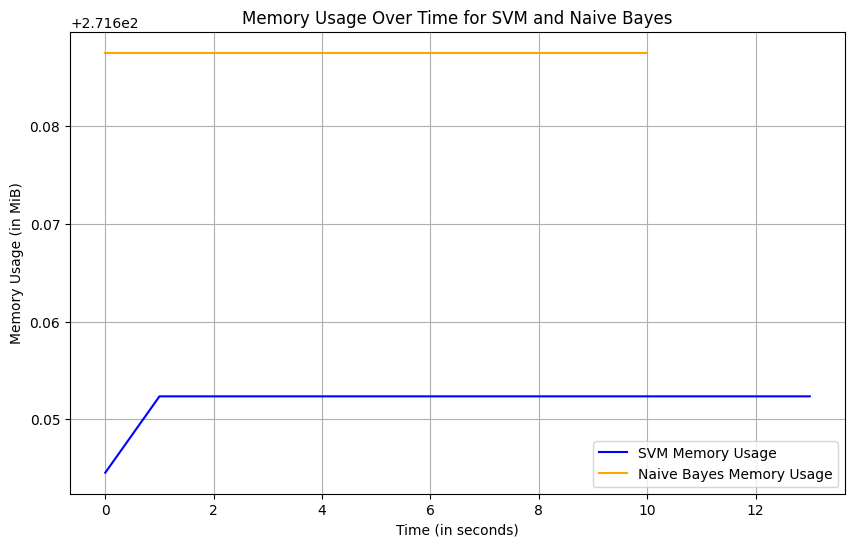

In [70]:
from memory_profiler import memory_usage

X = pd.DataFrame(np.abs(np.random.randn(1000, 20)))
y = pd.Series(np.random.randint(0, 2, size=1000))

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

def svm_train_and_predict():
    svm = SVC(kernel='linear', C=10, gamma=0.0001)
    svm.fit(X_train, y_train)
    predictions = svm.predict(X_test)

def nb_train_and_predict():
    nb = MultinomialNB(alpha=2.0, fit_prior=False)
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_test)

mem_usage_svm = memory_usage(svm_train_and_predict)
mem_usage_nb = memory_usage(nb_train_and_predict)

plt.figure(figsize=(10, 6))
plt.plot(mem_usage_svm, label="SVM Memory Usage", color='blue')
plt.plot(mem_usage_nb, label="Naive Bayes Memory Usage", color='orange')
plt.title("Memory Usage Over Time for SVM and Naive Bayes")
plt.xlabel("Time (in seconds)")
plt.ylabel("Memory Usage (in MiB)")
plt.legend(loc="best")
plt.grid(True)
plt.show()